# SETUP

## Check environment

In [1]:
USE_GPU = True

## Libraries

In [2]:
# System
import os
import glob
import shutil
import copy
import re
from datetime import datetime
import logging
import sys

# Data
import numpy as np
import pandas as pd

# Visualization
%matplotlib widget
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Data processing
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import joblib

# Model
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_percentage_error
from scipy.stats import pearsonr
from keras import Input, Model, Sequential
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Dropout, GRU, Conv1D, MaxPooling1D, Flatten, Attention, Concatenate
from keras.utils import plot_model
from keras.saving import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.losses import MeanAbsoluteError
from keras.losses import MeanAbsoluteError, MeanSquaredError
import keras.backend as K
from tqdm.keras import TqdmCallback
from tensorflow.keras import optimizers

# Append the custom libraries to system path
sys.path.append("/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project")

# Configure device
if not USE_GPU:
    print("Using CPU to train")
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
else:
    print("Using GPU to train")

# Custom libraries written by myself
from src.plot import plot_1_data, plot_2_data, plot_3_data, plot_prediction, plot_learning_curves
from src.reduction_model.lstm_s2s import LSTMSeq2SeqReduction
from src.reduction_model.gru_s2s import GRUSeq2SeqReduction
from src.reduction_model.cnnlstm_s2s import CNNLSTMSeq2SeqReduction
from src.prediction_model.lstm import LSTMPrediction, inferenceLSTM
from src.loop_model import generate_loopresults, choose_the_best
from src.reduce_data_utils import prepareReducedData
from src.data_utils import mice
from src.time_series_utils import splitTrainValidationTestTimeSeries, reframePastFuture, padPastFuture

# Configuration reader
from src.config_reader import ConfigurationReader

# Checking Tensorflow
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print(tf.config.list_physical_devices('CPU'))

E0000 00:00:1761490041.049829  309312 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761490041.056846  309312 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1761490041.072715  309312 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1761490041.072731  309312 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1761490041.072733  309312 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1761490041.072734  309312 computation_placer.cc:177] computation placer already registered. Please check linka

Using GPU to train
2.19.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## Configuration

In [3]:
conf = ConfigurationReader("/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/model_params.json").data
conf

{'dataset': {'aod2022': {'file_dir': '/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/MatchingData2022.xlsx',
   'target_start_date': '2022-01-01',
   'target_end_date': '2022-12-31'},
  'aod2021': {'file_dir': '/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/aod_data_daily.csv',
   'target_start_date': '2021-01-01',
   'target_end_date': '2021-12-31'},
  'mpair': {'file_dir': '/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/MPair.csv',
   'target_start_date': '2021-01-01',
   'target_end_date': '2022-12-31',
   'station_2022_dir': '/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/station2022.csv',
   'station_2018_2021_dir': '/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/station2018-2021.csv',
   'merged_data_dir': '/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/mpair_merged.csv',
   'merged_data_dir_all_locatio

# DATA FROM VIET

## Load dataset

In [4]:
datadict = {}
dataset_path = "/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/215-215-pm25-no-norm"

current_idx, current_feature_data, current_label_data = 0, None, None

for csv_file in sorted(glob.glob(f"{dataset_path}/*")):
    print(f"Working on {csv_file}")
    file_idx, file_type = csv_file.split("-")[-2].split("_")
    if file_idx != current_idx:
        datadict[int(current_idx)] = (current_feature_data, current_label_data)
        current_idx = file_idx
    if file_type == "x":
        current_feature_data = pd.read_csv(csv_file, index_col="date").drop(columns=["Unnamed: 0"])
        current_feature_data.columns = current_feature_data.columns.str.lower()
    else:
        current_label_data = pd.read_csv(csv_file, index_col="date").drop(columns=["Unnamed: 0"])
        current_label_data.columns = current_label_data.columns.str.lower()
datadict[int(current_idx)] = (current_feature_data, current_label_data)

display(datadict[0][0])
display(datadict[0][1])
display(datadict[1][0])
display(datadict[1][1])
display(datadict[2][0])
display(datadict[2][1])
display(datadict[3][0])
display(datadict[3][1])

Working on /le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/215-215-pm25-no-norm/lstms2s-mean-215-PM25_x+station_distance+date+hour_cos+hour_sin-PM25_y-215-0_x-no_norm.csv
Working on /le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/215-215-pm25-no-norm/lstms2s-mean-215-PM25_x+station_distance+date+hour_cos+hour_sin-PM25_y-215-0_y-no_norm.csv
Working on /le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/215-215-pm25-no-norm/lstms2s-mean-215-PM25_x+station_distance+date+hour_cos+hour_sin-PM25_y-215-1_x-no_norm.csv
Working on /le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/215-215-pm25-no-norm/lstms2s-mean-215-PM25_x+station_distance+date+hour_cos+hour_sin-PM25_y-215-1_y-no_norm.csv
Working on /le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/dataset/215-215-pm25-no-norm/lstms2s-mean-215-PM25_x+station_distance+date+hour_cos+hour_sin-PM25_y-215-2_x-no_norm.csv


,pm25_x,station_distance,hour_cos,hour_sin
date,,,,
2021-04-01 00:00:00,14.867356,0.0,1.000000,0.000000
2021-04-01 01:00:00,14.867356,0.0,0.965926,0.258819
2021-04-01 02:00:00,14.867356,0.0,0.866025,0.500000
2021-04-01 03:00:00,14.867356,0.0,0.707107,0.707107
2021-04-01 04:00:00,14.867356,0.0,0.500000,0.866025
...,...,...,...,...
2021-05-31 19:00:00,14.867356,0.0,0.258819,-0.965926
2021-05-31 20:00:00,14.867356,0.0,0.500000,-0.866025
2021-05-31 21:00:00,14.867356,0.0,0.707107,-0.707107


,pm25_y
date,
2021-04-01 00:00:00,14.867356
2021-04-01 01:00:00,14.867356
2021-04-01 02:00:00,14.867356
2021-04-01 03:00:00,14.867356
2021-04-01 04:00:00,14.867356
...,...
2021-05-31 19:00:00,14.867356
2021-05-31 20:00:00,14.867356
2021-05-31 21:00:00,14.867356


,pm25_x,station_distance,hour_cos,hour_sin
date,,,,
2021-07-01 00:00:00,12.635000,0.0,1.000000,0.000000
2021-07-01 01:00:00,11.911667,0.0,0.965926,0.258819
2021-07-01 02:00:00,12.200000,0.0,0.866025,0.500000
2021-07-01 03:00:00,11.686667,0.0,0.707107,0.707107
2021-07-01 04:00:00,10.125000,0.0,0.500000,0.866025
...,...,...,...,...
2021-08-31 19:00:00,14.867356,0.0,0.258819,-0.965926
2021-08-31 20:00:00,14.867356,0.0,0.500000,-0.866025
2021-08-31 21:00:00,14.867356,0.0,0.707107,-0.707107


,pm25_y
date,
2021-07-01 00:00:00,12.635000
2021-07-01 01:00:00,11.911667
2021-07-01 02:00:00,12.200000
2021-07-01 03:00:00,11.686667
2021-07-01 04:00:00,10.125000
...,...
2021-08-31 19:00:00,14.867356
2021-08-31 20:00:00,14.867356
2021-08-31 21:00:00,14.867356


,pm25_x,station_distance,hour_cos,hour_sin
date,,,,
2021-10-01 00:00:00,14.867356,0.0,1.000000,0.000000
2021-10-01 01:00:00,14.867356,0.0,0.965926,0.258819
2021-10-01 02:00:00,14.867356,0.0,0.866025,0.500000
2021-10-01 03:00:00,14.867356,0.0,0.707107,0.707107
2021-10-01 04:00:00,14.867356,0.0,0.500000,0.866025
...,...,...,...,...
2021-11-30 19:00:00,12.200000,0.0,0.258819,-0.965926
2021-11-30 20:00:00,9.750000,0.0,0.500000,-0.866025
2021-11-30 21:00:00,7.850000,0.0,0.707107,-0.707107


,pm25_y
date,
2021-10-01 00:00:00,14.867356
2021-10-01 01:00:00,14.867356
2021-10-01 02:00:00,14.867356
2021-10-01 03:00:00,14.867356
2021-10-01 04:00:00,14.867356
...,...
2021-11-30 19:00:00,12.200000
2021-11-30 20:00:00,9.750000
2021-11-30 21:00:00,7.850000


,pm25_x,station_distance,hour_cos,hour_sin
date,,,,
2022-01-01 00:00:00,13.133333,0.0,1.000000e+00,0.000000
2022-01-01 01:00:00,12.183333,0.0,9.659258e-01,0.258819
2022-01-01 02:00:00,10.850000,0.0,8.660254e-01,0.500000
2022-01-01 03:00:00,10.400000,0.0,7.071068e-01,0.707107
2022-01-01 04:00:00,9.916667,0.0,5.000000e-01,0.866025
...,...,...,...,...
2022-01-26 05:00:00,9.533333,0.0,2.588190e-01,0.965926
2022-01-26 06:00:00,9.966667,0.0,6.123234e-17,1.000000
2022-01-26 07:00:00,14.133333,0.0,-2.588190e-01,0.965926


,pm25_y
date,
2022-01-01 00:00:00,13.133333
2022-01-01 01:00:00,12.183333
2022-01-01 02:00:00,10.850000
2022-01-01 03:00:00,10.400000
2022-01-01 04:00:00,9.916667
...,...
2022-01-26 05:00:00,9.533333
2022-01-26 06:00:00,9.966667
2022-01-26 07:00:00,14.133333


## EDA

Handling for index 0


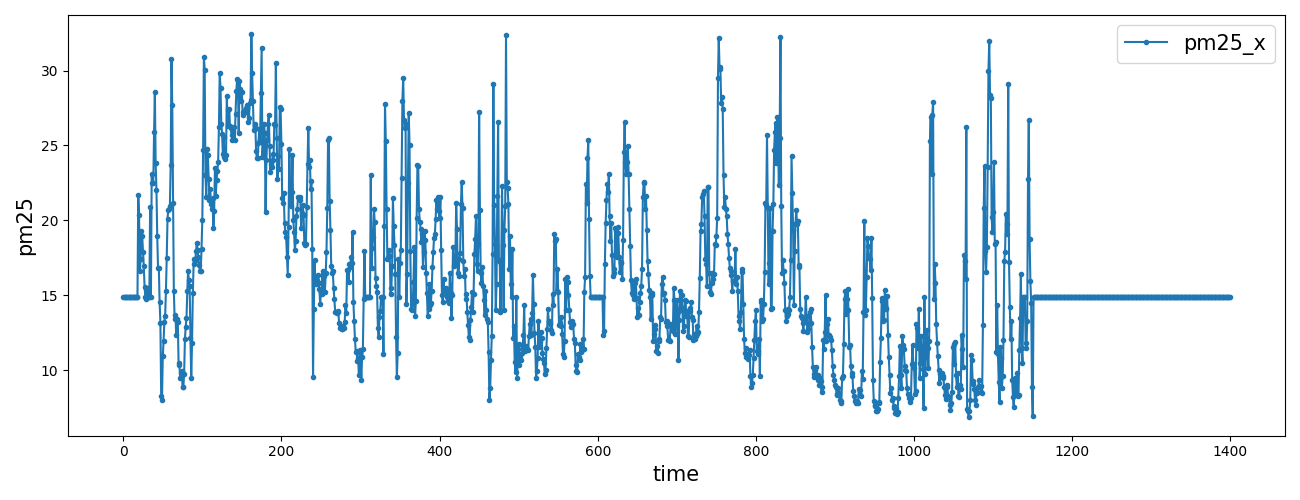

Handling for index 1


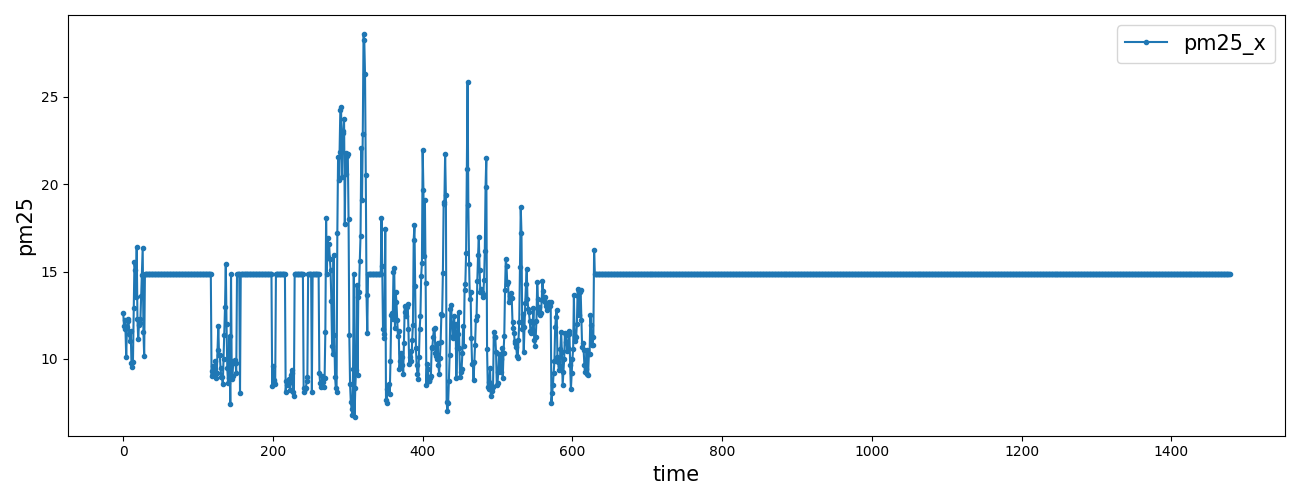

Handling for index 2


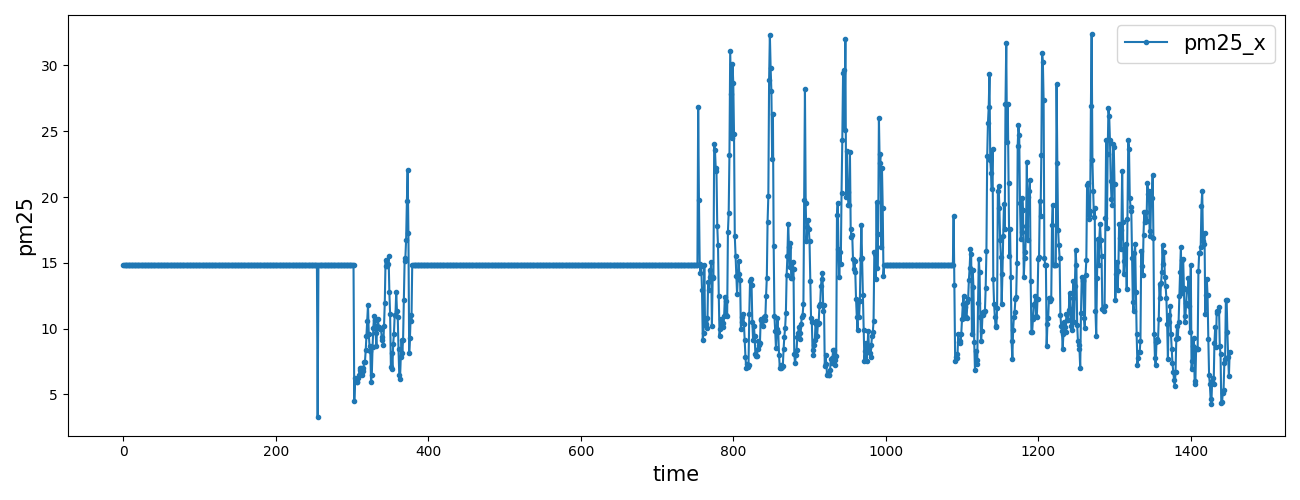

Handling for index 3


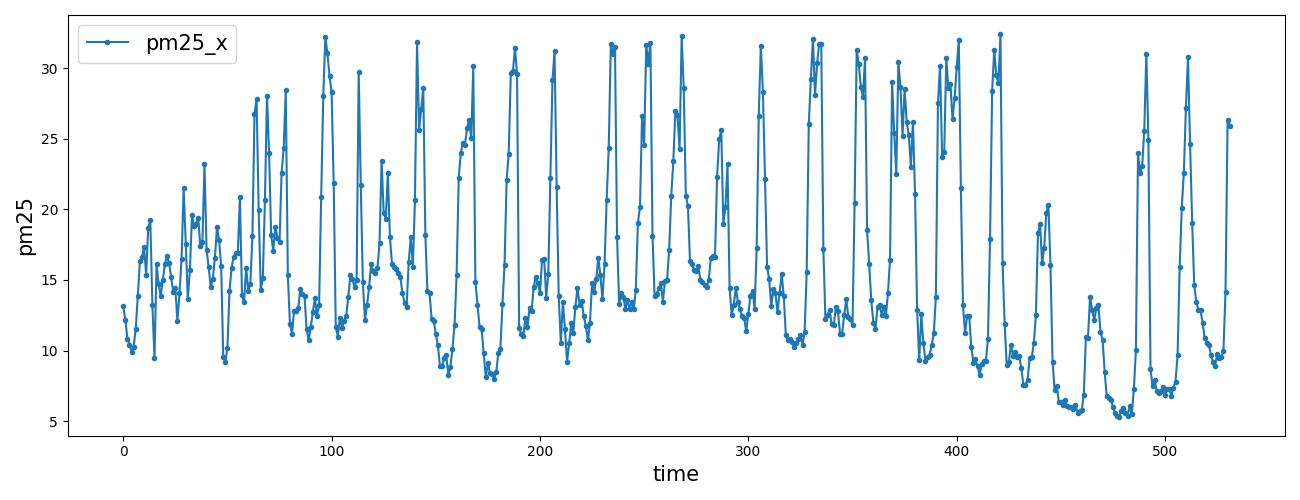

In [5]:
for idx, (feature, label) in datadict.items():
    print(f"Handling for index {idx}")
    plot_1_data(data=feature["pm25_x"],
                datalabel="pm25_x",
                xlabel="time",
                ylabel="pm25")

## Preprocessing

In [6]:
X = pd.concat([feature for (feature, _) in datadict.values()], axis=0).drop(columns=["pm25_x"])
y = pd.concat([label for (_, label) in datadict.values()], axis=0)
display(X)
display(y)

,station_distance,hour_cos,hour_sin
date,,,
2021-04-01 00:00:00,0.0,1.000000e+00,0.000000
2021-04-01 01:00:00,0.0,9.659258e-01,0.258819
2021-04-01 02:00:00,0.0,8.660254e-01,0.500000
2021-04-01 03:00:00,0.0,7.071068e-01,0.707107
2021-04-01 04:00:00,0.0,5.000000e-01,0.866025
...,...,...,...
2022-01-26 05:00:00,0.0,2.588190e-01,0.965926
2022-01-26 06:00:00,0.0,6.123234e-17,1.000000
2022-01-26 07:00:00,0.0,-2.588190e-01,0.965926


,pm25_y
date,
2021-04-01 00:00:00,14.867356
2021-04-01 01:00:00,14.867356
2021-04-01 02:00:00,14.867356
2021-04-01 03:00:00,14.867356
2021-04-01 04:00:00,14.867356
...,...
2022-01-26 05:00:00,9.533333
2022-01-26 06:00:00,9.966667
2022-01-26 07:00:00,14.133333


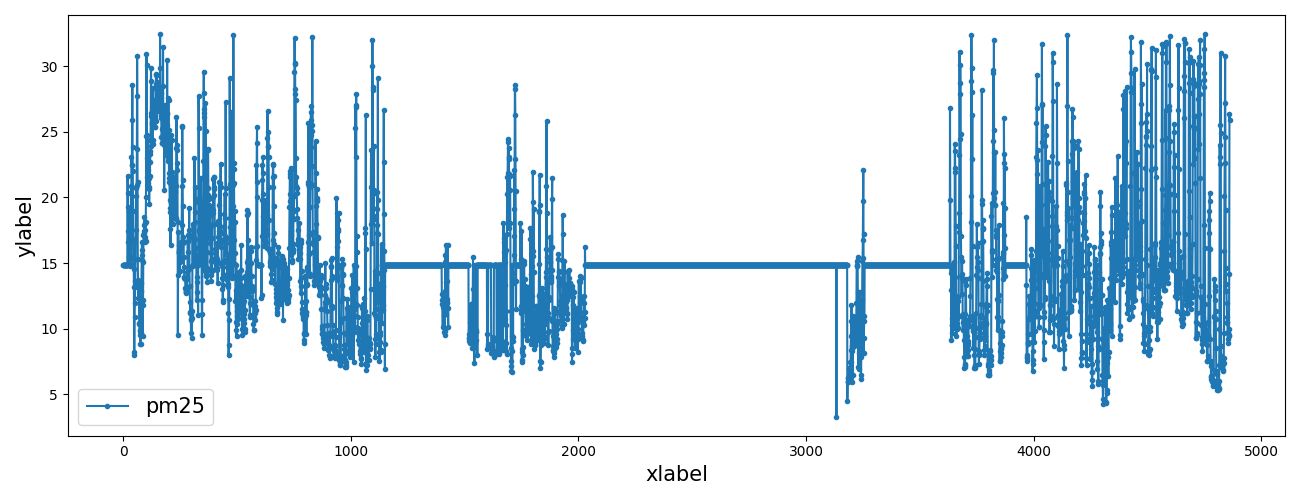

In [7]:
plot_1_data(data=y, datalabel="pm25")

### Data normalization

In [8]:
# Scaled features
feature_scaler = MinMaxScaler()
X_scaled = feature_scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled

,station_distance,hour_cos,hour_sin
0,0.0,1.000000,0.500000
1,0.0,0.982963,0.629410
2,0.0,0.933013,0.750000
3,0.0,0.853553,0.853553
4,0.0,0.750000,0.933013
...,...,...,...
4858,0.0,0.629410,0.982963
4859,0.0,0.500000,1.000000
4860,0.0,0.370590,0.982963
4861,0.0,0.250000,0.933013


In [9]:
# Scaled label
label_scaler = MinMaxScaler()
y_scaled = label_scaler.fit_transform(y)
y_scaled = pd.DataFrame(y_scaled, columns=y.columns)
y_scaled

,pm25_y
0,0.396851
1,0.396851
2,0.396851
3,0.396851
4,0.396851
...,...
4858,0.213730
4859,0.228607
4860,0.371651
4861,0.790486


## Dimensionality Reduction Comparation

### Evaluation board

In [10]:
evaluation_board = {'dim_reduction_method': [], 'dim_after_reduction': [], 'prediction': [], 'n_future': []} | {m: [] for m in LSTMPrediction.get_supported_metrics()}
evaluation_board

{'dim_reduction_method': [],
 'dim_after_reduction': [],
 'prediction': [],
 'n_future': [],
 'mae': [],
 'mse': [],
 'rmse': [],
 'r2': [],
 'mape': [],
 'mnbe': [],
 'r_coeff': [],
 'p_value': []}

### Model paramaters

In [11]:
n_past = 168
n_future = 4
#n_future = 24
#n_future = 48
#n_future = 72
n_features = 1
n_label = 1
latent_dim = 128

epochs = 100
batch_size = 256

In [12]:
# Calculate MNBE
def mean_normalized_bias_error(y_pred, y_actual):
    y_pred = np.array(y_pred)
    y_actual = np.array(y_actual)
    return np.mean((y_pred - y_actual) / np.mean(y_actual)) * 100

metrics_calculators = {
    "mae": mean_absolute_error,
    "mse": mean_squared_error,
    "rmse": root_mean_squared_error,
    "r2": r2_score,
    "mape": mean_absolute_percentage_error,
    "mnbe": mean_normalized_bias_error,
    "r_coeff": lambda a,b: pearsonr(a, b)[0]
}

### Data preparation

In [13]:
data = copy.deepcopy(y_scaled)

n = len(data)
train_indicator = round(0.8 * n)
train_data = data[:train_indicator]
test_data = data[train_indicator:]

newtraindata = train_data.to_numpy()
newtestdata = test_data.to_numpy()

# Split into encoder_input, decoder input and decoder output
m = np.arange(0, len(newtraindata)-(n_past+n_future)+1)
encoder_input_data = np.array([newtraindata[i:(i+n_past)] for i in m])           # encoder input
decoder_input_data = np.array([newtraindata[(i+n_past-1):(i+n_past+n_future-1)] for i in m]) # decoder input
decoder_output_data = np.array([newtraindata[(i+n_past):(i+n_past+n_future)] for i in m])     # decoder output
print(encoder_input_data.shape, decoder_input_data.shape, decoder_output_data.shape)

m = np.arange(0, len(newtestdata)-(n_past+n_future)+1)
encoder_input_testdata = np.array([newtestdata[i:(i+n_past)] for i in m])           # encoder input
decoder_input_testdata = np.array([newtestdata[(i+n_past-1):(i+n_past+n_future-1)] for i in m]) # decoder input
decoder_output_testdata = np.array([newtestdata[(i+n_past):(i+n_past+n_future)] for i in m])     # decoder output
print(encoder_input_testdata.shape, decoder_input_testdata.shape, decoder_output_testdata.shape)

# Split into train and test
m = np.arange(0, len(newtraindata)-(n_past+n_future)+1)
X_train = np.array([newtraindata[i:(i+n_past)] for i in m])
y_train = np.array([newtraindata[(i+n_past):(i+n_past+n_future)] for i in m])
print(X_train.shape, y_train.shape)

m = np.arange(0, len(newtestdata)-(n_past+n_future)+1)
X_test = np.array([newtestdata[i:(i+n_past)] for i in m])
y_test = np.array([newtestdata[(i+n_past):(i+n_past+n_future)] for i in m])
print(X_test.shape, y_test.shape)

# Split into train and test with shifted value
n_shifted = 4
# Example: with n_shfited = 4,
# input_sequence = t-168, t-167, ..., t
# output_sequence = t + 5, t + 6, t + 7
m = np.arange(0, len(newtraindata)-(n_past+n_future+n_shifted)+1)
X_train_shifted = np.array([newtraindata[i:(i+n_past)] for i in m])
y_train_shifted = np.array([newtraindata[(i+n_past+n_shifted):(i+n_past+n_shifted+n_future)] for i in m])
print(X_train_shifted.shape, y_train_shifted.shape)

m = np.arange(0, len(newtestdata)-(n_past+n_future+n_shifted)+1)
X_test_shifted = np.array([newtestdata[i:(i+n_past)] for i in m])
y_test_shifted = np.array([newtestdata[(i+n_shifted+n_past):(i+n_past+n_shifted+n_future)] for i in m])
print(X_test_shifted.shape, y_test_shifted.shape)

(3719, 168, 1) (3719, 4, 1) (3719, 4, 1)
(802, 168, 1) (802, 4, 1) (802, 4, 1)
(3719, 168, 1) (3719, 4, 1)
(802, 168, 1) (802, 4, 1)
(3715, 168, 1) (3715, 4, 1)
(798, 168, 1) (798, 4, 1)


In [25]:
X_train[0]

array([[0.39685092],
       [0.39685092],
       [0.39685092],
       [0.39685092],
       [0.39685092],
       [0.39685092],
       [0.39685092],
       [0.39685092],
       [0.39685092],
       [0.39685092],
       [0.39685092],
       [0.39685092],
       [0.39685092],
       [0.39685092],
       [0.39685092],
       [0.39685092],
       [0.39685092],
       [0.39685092],
       [0.39685092],
       [0.63027579],
       [0.58455879],
       [0.45719202],
       [0.48528595],
       [0.54799663],
       [0.53639546],
       [0.49970483],
       [0.46726235],
       [0.42077237],
       [0.39619379],
       [0.39343507],
       [0.41284825],
       [0.41886096],
       [0.39685092],
       [0.39685092],
       [0.60414634],
       [0.39685092],
       [0.67842675],
       [0.65843125],
       [0.65882746],
       [0.77503676],
       [0.86641354],
       [0.7040295 ],
       [0.64314979],
       [0.53776928],
       [0.46382928],
       [0.46480199],
       [0.38601311],
       [0.338

In [27]:
newtraindata[0:176]

array([[0.39685092],
       [0.39685092],
       [0.39685092],
       [0.39685092],
       [0.39685092],
       [0.39685092],
       [0.39685092],
       [0.39685092],
       [0.39685092],
       [0.39685092],
       [0.39685092],
       [0.39685092],
       [0.39685092],
       [0.39685092],
       [0.39685092],
       [0.39685092],
       [0.39685092],
       [0.39685092],
       [0.39685092],
       [0.63027579],
       [0.58455879],
       [0.45719202],
       [0.48528595],
       [0.54799663],
       [0.53639546],
       [0.49970483],
       [0.46726235],
       [0.42077237],
       [0.39619379],
       [0.39343507],
       [0.41284825],
       [0.41886096],
       [0.39685092],
       [0.39685092],
       [0.60414634],
       [0.39685092],
       [0.67842675],
       [0.65843125],
       [0.65882746],
       [0.77503676],
       [0.86641354],
       [0.7040295 ],
       [0.64314979],
       [0.53776928],
       [0.46382928],
       [0.46480199],
       [0.38601311],
       [0.338

In [30]:
print(y_train[0])
print(y_train_shifted[0])

[[0.73115072]
 [0.71633132]
 [0.71501531]
 [0.75111973]]
[[0.78316168]
 [0.75769977]
 [0.86566971]
 [0.96705961]]


In [14]:
stop

NameError: name 'stop' is not defined

### GRU-Seq2Seq separate encoder/decoder

In [ ]:
# encoder layers
encoder_inputs = Input(shape=(None, n_label))
encoder_gru_1 = GRU(128, return_sequences=True, activation="relu")
encoder_gru_1_outputs = encoder_gru_1(encoder_inputs)
encoder_gru_2 = GRU(latent_dim, return_sequences=True, return_state=True, activation="relu", dropout=0.2)
encoder_gru_2_outputs, encoder_gru_state_h = encoder_gru_2(encoder_gru_1_outputs)
encoder_states = [encoder_gru_state_h]
# Decoder layers
decoder_inputs = Input(shape=(None, n_label))
decoder_gru_1 = GRU(latent_dim, return_sequences=True, activation="relu")
decoder_gru_1_outputs = decoder_gru_1(decoder_inputs, initial_state=encoder_states)
decoder_gru_2 = GRU(128, return_sequences=True, return_state=True, activation="relu", dropout=0.2)
decoder_gru_2_outputs, decoder_gru_state_h = decoder_gru_2(decoder_gru_1_outputs)
decoder_dense = TimeDistributed(Dense(n_label))
decoder_dense_outputs = decoder_dense(decoder_gru_2_outputs)
# Compile the model
grus2smodel = Model([encoder_inputs, decoder_inputs], decoder_dense_outputs, name="seq2seq")
grus2smodel.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError())
display(grus2smodel.summary())

print(f"grus2smodel.input_shape = {grus2smodel.input_shape}, grus2smodel.output_shape = {grus2smodel.output_shape}")

# Fit model
history = grus2smodel.fit([encoder_input_data, decoder_input_data], decoder_output_data,
                validation_split=0.2,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=False,
                callbacks = [
                    EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True),
                    TqdmCallback(verbose=1)
                ],
                verbose=1)
plot_learning_curves(history)

# Define encoder and decoder models
encoder_model = Model(encoder_inputs, encoder_states, name="encoder")
display(encoder_model.summary())

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h]
decoder_gru_1_outputs= decoder_gru_1(decoder_inputs, initial_state=decoder_states_inputs)
decoder_gru_2_outputs, decoder_gru_state_h  = decoder_gru_2(decoder_gru_1_outputs)
decoder_states = [decoder_gru_state_h]
decoder_outputs = decoder_dense(decoder_gru_2_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states, name="decoder")
display(decoder_model.summary())

In [ ]:
# Example inference
print("encoder_input_testdata.shape =", encoder_input_testdata.shape)
print("decoder_input_testdata.shape =", decoder_input_testdata.shape)
print("decoder_output_testdata.shape =", decoder_output_testdata.shape)

# Test with single sample
enc_in = encoder_input_testdata[400:401]
dec_in = decoder_input_testdata[400:401]
dec_out = decoder_output_testdata[400]
print("enc_in.shape =", enc_in.shape)
print("dec_in.shape =", dec_in.shape)
print("dec_out.shape =", dec_out.shape)

print(f"encoder_model.input_shape = {encoder_model.input_shape}, encoder_model.output_shape = {encoder_model.output_shape}")
print(f"decoder_model.input_shape = {decoder_model.input_shape}, decoder_model.output_shape = {decoder_model.output_shape}")

'''
state = encoder_model.predict(enc_in)
y_pred, _ = decoder_model.predict([dec_in, state])
y_pred = y_pred.reshape(-1, 1)
print(y_pred.shape)
'''

'''
y_pred = []
for t in range(n_future):
    # predict next char
    yhat, h = decoder_model.predict([dec_in, state])
    print("yhat.shape", yhat.shape)
    # store prediction
    y_pred.append(yhat[0,t,0])
    # update state
    state = h
    dec_in = yhat

y_pred = np.expand_dims(np.array(y_pred), -1)
'''

# encode
state = [encoder_model.predict(enc_in)]
# start of sequence input
target_seq = np.array([0.0 for _ in range(n_features)]).reshape(1, -1, 1)
print(target_seq.shape)
target_seq[0, 0] = 0.0
# collect predictions
output = list()
for t in range(n_future):
    # predict next char
    print(f"target_seq = {target_seq}")
    print(f"target_seq.shape = {target_seq.shape}")
    yhat, h = decoder_model.predict([target_seq] + state)
    # store prediction
    output.append(yhat[0,t,:])
    print(f"yhat.shape = {yhat.shape}")
    print(f"yhat[0, t, :].shape = {yhat[0, t, :].shape}")
    # update state
    state = [h]
    # update target sequence
    target_seq = np.concatenate((target_seq, yhat[0, t, :].reshape(1, 1, 1)), axis=1)

y_pred = np.array(output)
print(y_pred.shape)

In [ ]:
inv_y_pred = label_scaler.inverse_transform(y_pred)
inv_dec_out = label_scaler.inverse_transform(dec_out)

print(mean_absolute_error(inv_y_pred, inv_dec_out))

plot_2_data(data1=inv_y_pred[1:], datalabel1="prediction", data2=inv_dec_out[:-1], datalabel2="actual")

In [ ]:
stop

### LSTM encoder-decoder

In [ ]:
# layers
inputs = Input(shape=(n_past, n_label))
lstm_1 = LSTM(128, return_sequences=True, activation="relu")(inputs)
lstm_2, state_h, state_c = LSTM(64, return_state=True, activation="relu", dropout=0.2)(lstm_1)
repeat_vectors = RepeatVector(n_future)(lstm_2)
lstm_3 = LSTM(64, return_sequences=True, activation="relu")(repeat_vectors, initial_state=[state_h, state_c])
lstm_4 = LSTM(128, return_sequences=True, activation="relu", dropout=0.2)(lstm_3)
outputs = TimeDistributed(Dense(n_label))(lstm_4)
# Compile the model
model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError())
display(model.summary())

print(f"model.input_shape = {model.input_shape}, model.output_shape = {model.output_shape}")

# Fit model
history = model.fit(X_train, y_train,
                validation_split=0.2,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=False,
                callbacks = [
                    EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True),
                    TqdmCallback(verbose=1)
                ],
                verbose=1)
plot_learning_curves(history)

y_pred = model.predict(X_test)
print(y_pred.shape)

for t in range(n_future):
    print(f"t = {t}")
    inv_y_pred = label_scaler.inverse_transform(y_pred[:, t, :])
    inv_y_test = label_scaler.inverse_transform(y_test[:, t, :])
    print(mean_absolute_error(inv_y_pred, inv_y_test))
    plot_2_data(data1=inv_y_pred, datalabel1="ypred", data2=inv_y_test, datalabel2="decout")

### GRU encoder-decoder

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 168, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_16 (GRU)        │ (None, 168, 128)  │     50,304 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_17 (GRU)        │ [(None, 64),      │     37,248 │ gru_16[0][0]      │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_4     │ (None, 4, 64)     │          0 │ gru_17[0][0]      │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_18 (GRU)        │ (None, 4, 64)     │     24,960 │ repeat_vector_4[… │
│                     │                   │            │ gru_17[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_19 (GRU)        │ (None, 4, 128)    │     74,496 │ gru_18[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_15 │ (None, 4, 1)      │        129 │ gru_19[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 187,137 (731.00 KB)

 Trainable params: 187,137 (731.00 KB)

 Non-trainable params: 0 (0.00 B)

None

model.input_shape = (None, 168, 1), model.output_shape = (None, 4, 1)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 911ms/step - loss: 0.1068 - val_loss: 0.0259
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0325 - val_loss: 0.0262
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0230 - val_loss: 0.0199
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0186 - val_loss: 0.0173
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0144 - val_loss: 0.0154
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0134 - val_loss: 0.0144
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0123 - val_loss: 0.0138
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0119 - val_loss: 0.0137
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0119 - val_loss: 0.0133
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0113 - val_loss: 0.0131
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0111 - val_loss: 0.0129
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/st

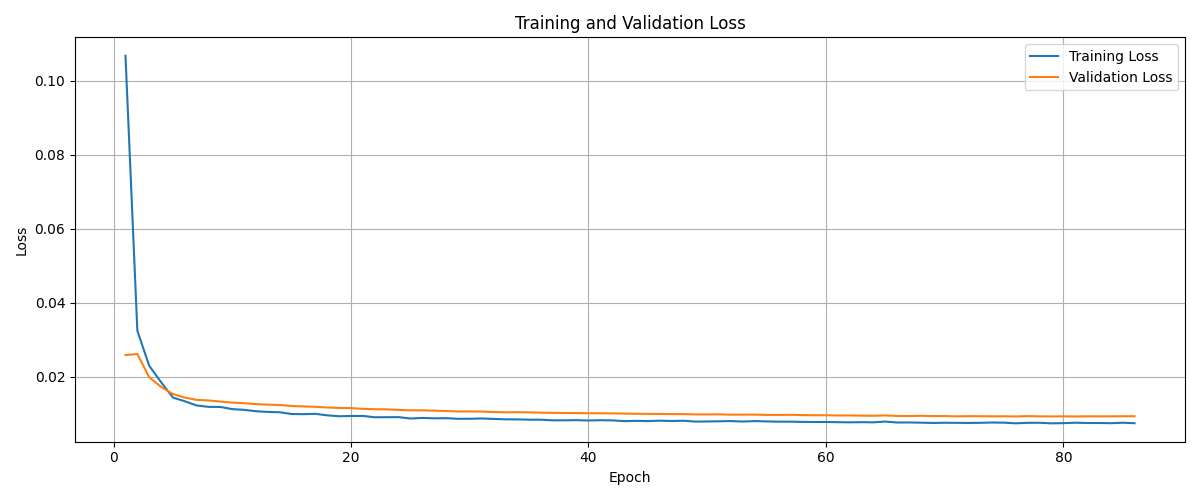

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step
(802, 4, 1)
t = 0
1.2700997088114216


/le_thanh_van_118/workspace/hiep_workspace/air_quality_index_project/src/plot.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=figsize)


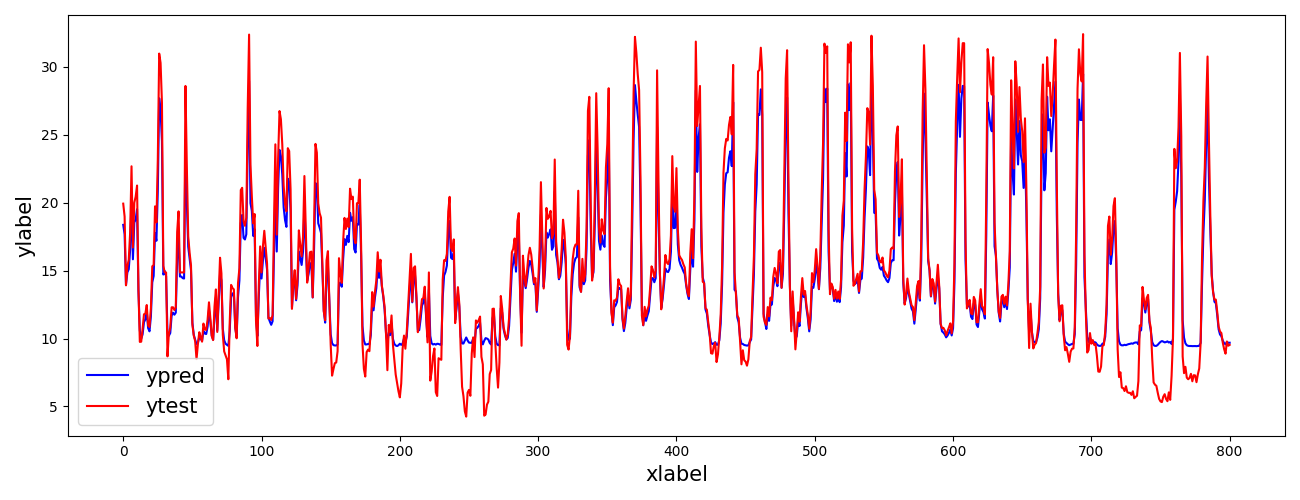

t = 1
1.8456022613445746


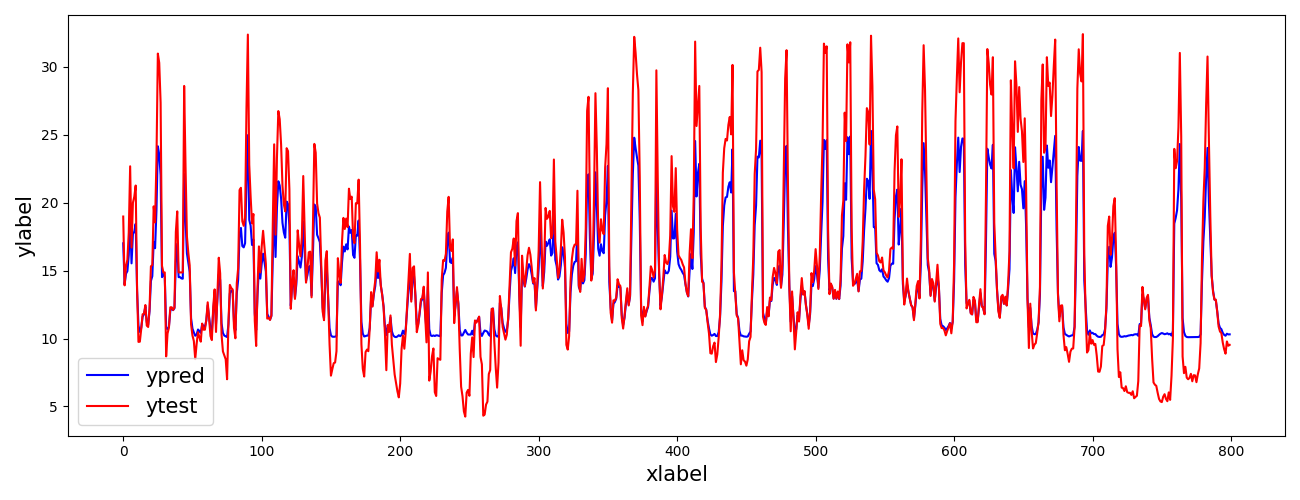

t = 2
2.1182093725126996


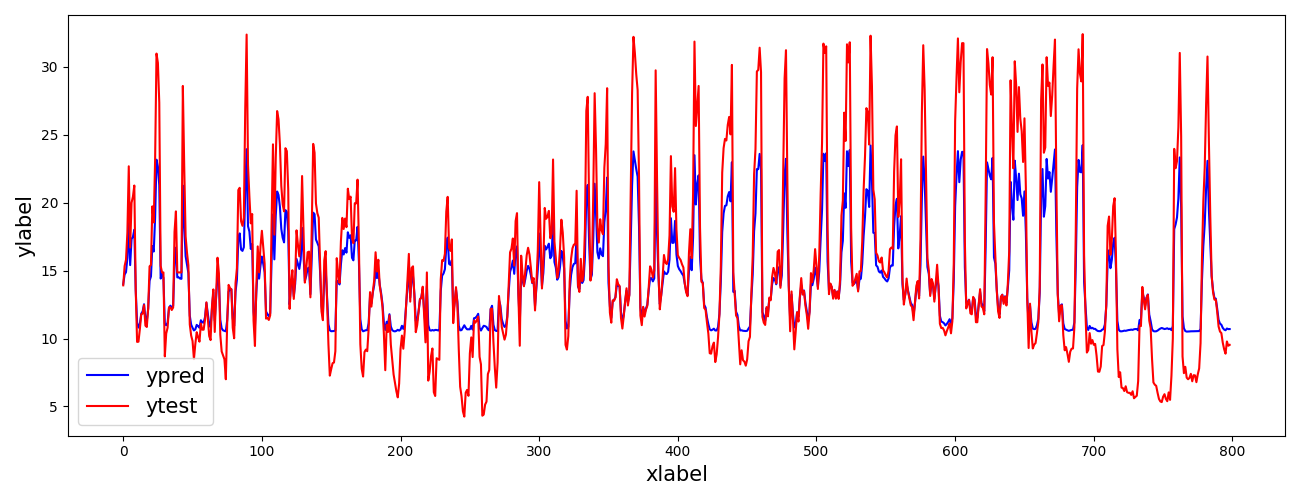

t = 3
2.3531731234489186


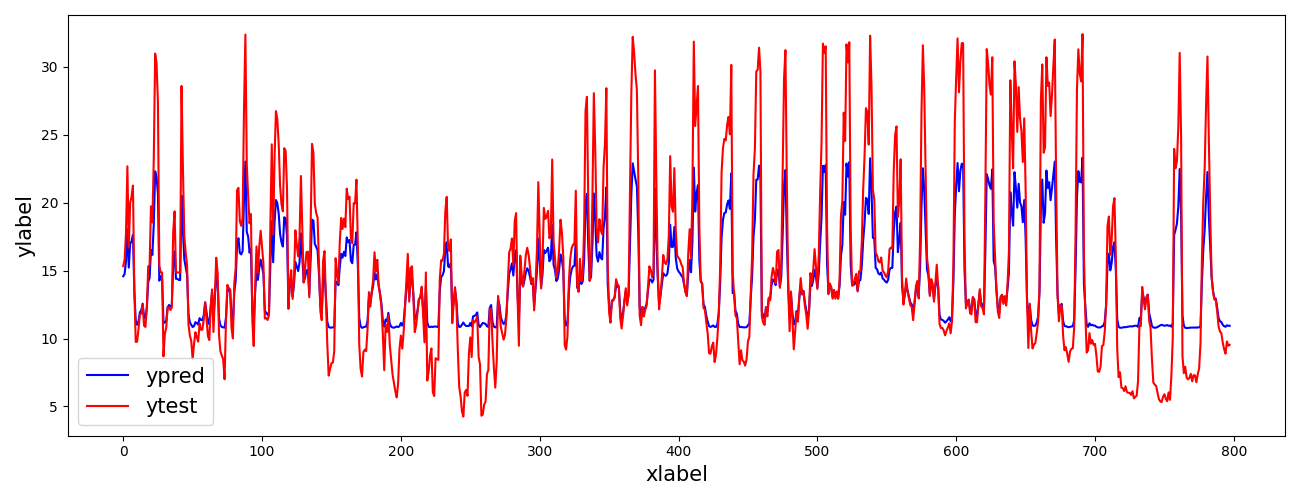

In [19]:
# layers
inputs = Input(shape=(n_past, n_label))
lstm_1 = GRU(128, return_sequences=True, activation="relu")(inputs)
lstm_2, state_h = GRU(64, return_state=True, activation="relu", dropout=0.2)(lstm_1)
repeat_vectors = RepeatVector(n_future)(lstm_2)
lstm_3 = GRU(64, return_sequences=True, activation="relu")(repeat_vectors, initial_state=[state_h])
lstm_4 = GRU(128, return_sequences=True, activation="relu", dropout=0.2)(lstm_3)
dense_1 = TimeDistributed(Dense(64))(lstm_4)
dense_2 = TimeDistributed(Dense(32))(dense_1)
outputs = TimeDistributed(Dense(n_label))(lstm_4)
# Compile the model
model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError())
display(model.summary())

print(f"model.input_shape = {model.input_shape}, model.output_shape = {model.output_shape}")

# Fit model
history = model.fit(X_train, y_train,
                validation_split=0.2,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=False,
                callbacks = [
                    EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True),
                    TqdmCallback(verbose=1)
                ],
                verbose=1)
plot_learning_curves(history)

y_pred = model.predict(X_test)
print(y_pred.shape)

for t in range(n_future):
    print(f"t = {t}")
    inv_y_pred = label_scaler.inverse_transform(y_pred[:, t, :])[t+1:]
    inv_y_test = label_scaler.inverse_transform(y_test[:, t, :])[:-t-1]
    print(mean_absolute_error(inv_y_pred, inv_y_test))
    plot_2_data(data1=inv_y_pred, datalabel1="ypred", data2=inv_y_test, datalabel2="ytest")

### GRU encoder-decoder shifted

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 168, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_20 (GRU)        │ (None, 168, 128)  │     50,304 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_21 (GRU)        │ [(None, 64),      │     37,248 │ gru_20[0][0]      │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_5     │ (None, 4, 64)     │          0 │ gru_21[0][0]      │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_22 (GRU)        │ (None, 4, 64)     │     24,960 │ repeat_vector_5[… │
│                     │                   │            │ gru_21[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_23 (GRU)        │ (None, 4, 128)    │     74,496 │ gru_22[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_19 │ (None, 4, 1)      │        129 │ gru_23[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 187,137 (731.00 KB)

 Trainable params: 187,137 (731.00 KB)

 Non-trainable params: 0 (0.00 B)

None

model.input_shape = (None, 168, 1), model.output_shape = (None, 4, 1)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 944ms/step - loss: 0.1011 - val_loss: 0.0332
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0314 - val_loss: 0.0290
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0224 - val_loss: 0.0227
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0176 - val_loss: 0.0196
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0153 - val_loss: 0.0182
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0141 - val_loss: 0.0180
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0142 - val_loss: 0.0177
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0137 - val_loss: 0.0177
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0140 - val_loss: 0.0177
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0137 - val_loss: 0.0176
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0136 - val_loss: 0.0176
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/st

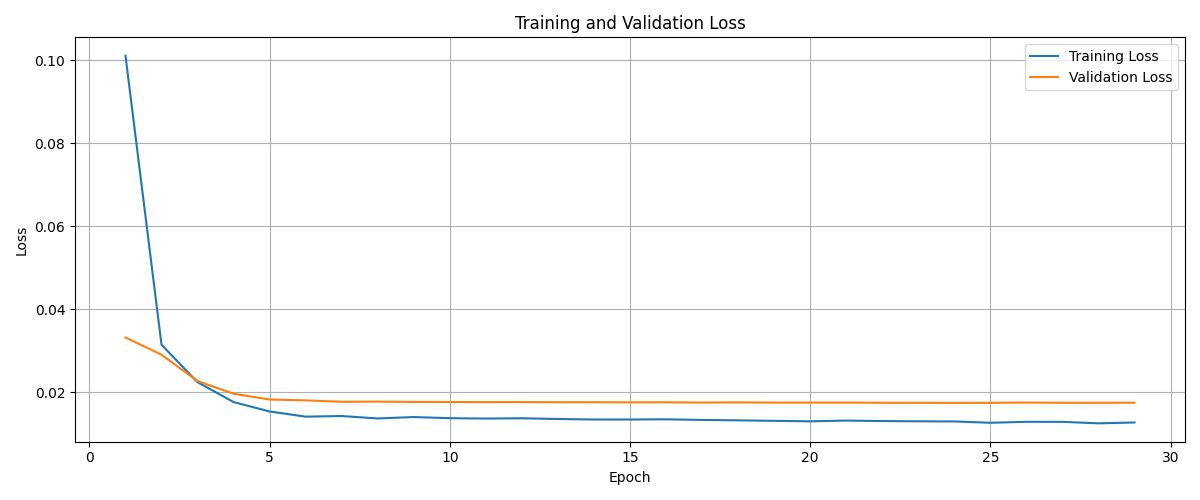

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step
(798, 4, 1)
t = 0
5.028924221520221


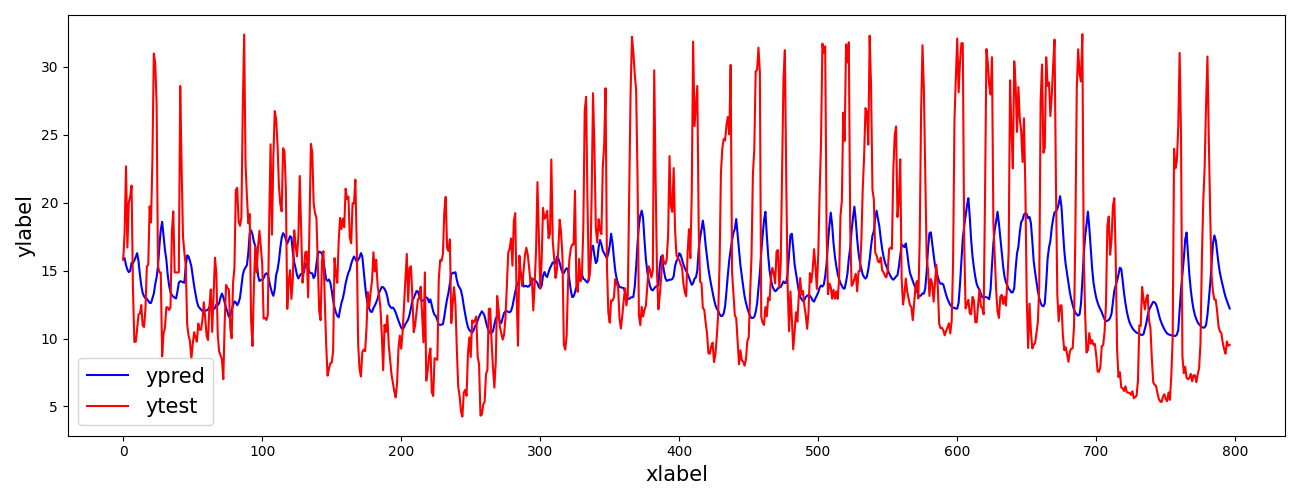

t = 1
4.987880260894494


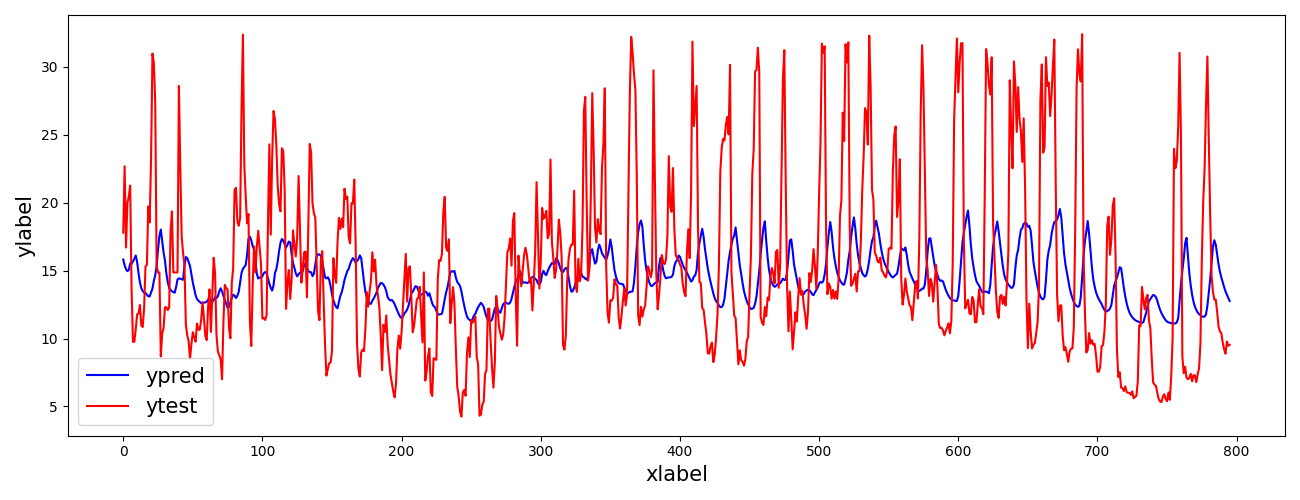

t = 2
4.95598888724704


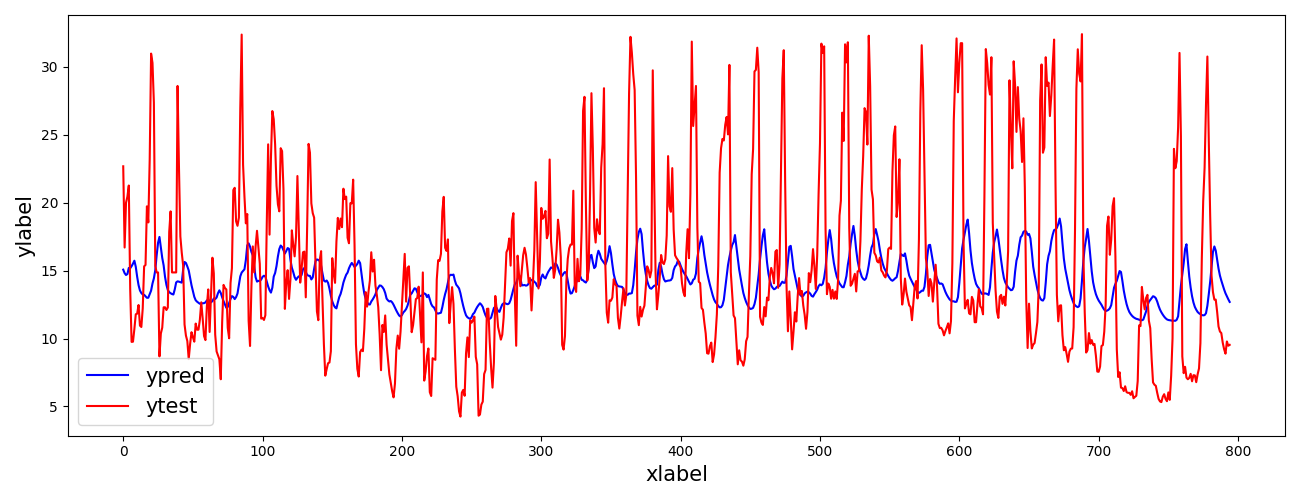

t = 3
4.924149303245844


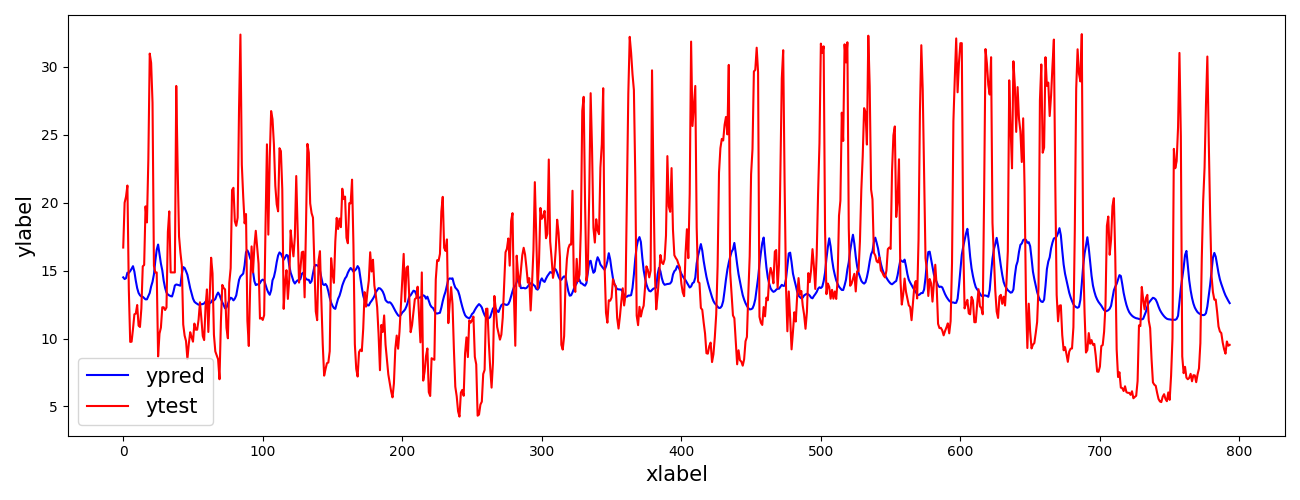

In [20]:
# layers
inputs = Input(shape=(n_past, n_label))
lstm_1 = GRU(128, return_sequences=True, activation="relu")(inputs)
lstm_2, state_h = GRU(64, return_state=True, activation="relu", dropout=0.2)(lstm_1)
repeat_vectors = RepeatVector(n_future)(lstm_2)
lstm_3 = GRU(64, return_sequences=True, activation="relu")(repeat_vectors, initial_state=[state_h])
lstm_4 = GRU(128, return_sequences=True, activation="relu", dropout=0.2)(lstm_3)
outputs = TimeDistributed(Dense(n_label))(lstm_4)
dense_1 = TimeDistributed(Dense(64))(lstm_4)
dense_2 = TimeDistributed(Dense(32))(dense_1)
outputs = TimeDistributed(Dense(n_label))(lstm_4)
# Compile the model
model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError())
display(model.summary())

print(f"model.input_shape = {model.input_shape}, model.output_shape = {model.output_shape}")

# Fit model
history = model.fit(X_train_shifted, y_train_shifted,
                validation_split=0.2,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=False,
                callbacks = [
                    EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True),
                    TqdmCallback(verbose=1)
                ],
                verbose=1)
plot_learning_curves(history)

y_pred = model.predict(X_test_shifted)
print(y_pred.shape)

for t in range(n_future):
    print(f"t = {t}")
    inv_y_pred = label_scaler.inverse_transform(y_pred[:, t, :])[t+1:]
    inv_y_test = label_scaler.inverse_transform(y_test_shifted[:, t, :])[:-t-1]
    print(mean_absolute_error(inv_y_pred, inv_y_test))
    plot_2_data(data1=inv_y_pred, datalabel1="ypred", data2=inv_y_test, datalabel2="ytest")

### LSTM-Seq2Seq

In [ ]:
# Encoder layers
encoder_inputs = Input(shape=(n_past, n_features))
encoder_lstm_1 = LSTM(128, return_sequences=True, activation="relu")(encoder_inputs)
encoder_lstm_2, state_h, state_c = LSTM(64, return_state=True, activation="relu")(encoder_lstm_1)
encoder_dropout = Dropout(0.2)(encoder_lstm_2)
encoder_dense = Dense(latent_dim)(encoder_dropout)
# Repeat layer
decoder_repeat_vector = RepeatVector(n_future)(encoder_dense)
# Decoder layers
decoder_lstm_1 = LSTM(64, return_sequences=True, activation="relu")(decoder_repeat_vector, initial_state=[state_h, state_c])
decoder_lstm_2 = LSTM(128, return_sequences=True, activation="relu")(decoder_lstm_1)
decoder_dropout = Dropout(0.2)(decoder_lstm_2)
decoder_outputs = TimeDistributed(Dense(n_label))(decoder_dropout)
# Compile the model
lstms2smodel = Model(encoder_inputs, decoder_outputs)
lstms2smodel.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError())
display(lstms2smodel.summary())

# Fit model
history = lstms2smodel.fit(X_train, y_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=0.2,
                shuffle=False,
                callbacks = [
                    EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True),
                    TqdmCallback(verbose=1)
                ],
                verbose=1)
plot_learning_curves(history)

# Predict data
y_pred = lstms2smodel.predict(X_test)

# Evaluation
for day in range(n_future):
    print(f"Day = {day}")
    inv_y_test = label_scaler.inverse_transform(y_test[:, day, :])[:-(day+1)]
    inv_y_pred = label_scaler.inverse_transform(y_pred[:, day, :])[(day+1):]
    for metric, calculator in metrics_calculators.items():
        print(f"{metric}: {calculator(inv_y_pred, inv_y_test)}")
    plot_2_data(data1=inv_y_test, datalabel1="y_test", data2=inv_y_pred, datalabel2="y_predicted")

### GRU-Seq2Seq Attention

In [ ]:
# encoder layers
encoder_inputs = Input(shape=(n_past, n_features))
encoder_gru_1 = GRU(128, return_sequences=True, dropout=0.2, activation="relu")(encoder_inputs)
encoder_gru_2, state_h = GRU(64, return_state = True, dropout=0.2, activation="relu")(encoder_gru_1)
encoder_dense = Dense(latent_dim)(encoder_gru_2)
# Repeat layer
decoder_repeat_vector = RepeatVector(n_future)(encoder_dense)
# Decoder layers
decoder_gru_1 = GRU(64, return_sequences=True, dropout=0.2, activation="relu")(decoder_repeat_vector, initial_state=state_h)
decoder_gru_2 = GRU(128, return_sequences=True, dropout=0.2, activation="relu")(decoder_gru_1)
attention_outputs = Attention([decoder_gru_2, encoder_dense])
decoder_concat_input = Concatenate(axis=-1)([decoder_gru_2, attention_outputs])
decoder_outputs = TimeDistributed(Dense(n_label))(decoder_concat_input)
# Compile the model
grus2smodel = Model(encoder_inputs, decoder_outputs)
grus2smodel.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError())
display(grus2smodel.summary())

# Fit model
history = grus2smodel.fit(X_train, y_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=0.2,
                shuffle=False,
                callbacks = [
                    EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True),
                    TqdmCallback(verbose=1)
                ],
                verbose=1)
plot_learning_curves(history)

# Predict data
y_pred = grus2smodel.predict(X_test)

# Evaluation
for day in range(n_future):
    print(f"Day = {day}")
    inv_y_test = label_scaler.inverse_transform(y_test[:, day, :])[:-(day+1)]
    inv_y_pred = label_scaler.inverse_transform(y_pred[:, day, :])[(day+1):]
    for metric, calculator in metrics_calculators.items():
        print(f"{metric}: {calculator(inv_y_pred, inv_y_test)}")
    plot_2_data(data1=inv_y_test, datalabel1="y_test", data2=inv_y_pred, datalabel2="y_predicted")

### CNN-LSTM Seq2seq

In [ ]:
# Encoder layers
encoder_inputs = Input(shape=(n_past, n_features))
encoder_cnn_1 = Conv1D(filters=128, kernel_size=2, activation="relu")(encoder_inputs)
encoder_max_pooling_1 = MaxPooling1D(pool_size=2)(encoder_cnn_1)
encoder_cnn_2 = Conv1D(filters=64, kernel_size=2, activation="relu")(encoder_max_pooling_1)
encoder_max_pooling_2 = MaxPooling1D(pool_size=2)(encoder_cnn_2)
encoder_lstm, state_h, state_c = LSTM(64, return_state=True, activation="relu")(encoder_max_pooling_2)
encoder_dropout = Dropout(0.2)(encoder_lstm)
encoder_dense = Dense(latent_dim)(encoder_dropout)
# Repeat layer
decoder_repeat_vector = RepeatVector(n_future)(encoder_dense)
# Decoder layers
decoder_lstm_1 = LSTM(64, return_sequences=True, activation="relu")(decoder_repeat_vector, initial_state=[state_h, state_c])
decoder_dropout = Dropout(0.2)(decoder_lstm_1)
decoder_outputs = TimeDistributed(Dense(n_label))(decoder_dropout)
# Compile the model
cnncnnlstms2smodel = Model(encoder_inputs, decoder_outputs)
# Compile the model
cnnlstms2smodel = Model(encoder_inputs, decoder_outputs)
cnnlstms2smodel.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError())
display(cnnlstms2smodel.summary())

# Fit model
history = cnnlstms2smodel.fit(X_train, y_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=0.2,
                shuffle=False,
                callbacks = [
                    #EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True),
                    TqdmCallback(verbose=1)
                ],
                verbose=1)
plot_learning_curves(history)

# Predict data
y_pred = cnnlstms2smodel.predict(X_test)

# Evaluation
for day in range(n_future):
    print(f"Day = {day}")
    inv_y_test = label_scaler.inverse_transform(y_test[:, day, :])[:-(day+1)]
    inv_y_pred = label_scaler.inverse_transform(y_pred[:, day, :])[(day+1):]
    for metric, calculator in metrics_calculators.items():
        print(f"{metric}: {calculator(inv_y_pred, inv_y_test)}")
    plot_2_data(data1=inv_y_test, datalabel1="y_test", data2=inv_y_pred, datalabel2="y_predicted")

## Evaluation board

In [ ]:
pd.DataFrame(evaluation_board)